<a href="https://colab.research.google.com/github/LGM-kr/math1/blob/main/%EC%8A%A4%EB%A7%88%ED%8A%B8%EC%B6%95%EC%82%B0_%EC%9C%84%ED%97%98%EC%98%88%EC%B8%A1_%EB%B6%84%EC%84%9D_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ 데이터 전처리 완료: 총 19594건의 데이터가 준비되었습니다.
✅ THI 계산 및 위험 라벨링 완료.
라벨 분포:
 Risk_Label
0    12222
1     4268
2      776
3     2328
Name: count, dtype: int64

📊 [모델 성능 요약]
 - Naive Bayes 정확도: 0.9678
 - Logistic Regression 정확도: 0.9678
 - Cross Entropy Loss: 0.0492


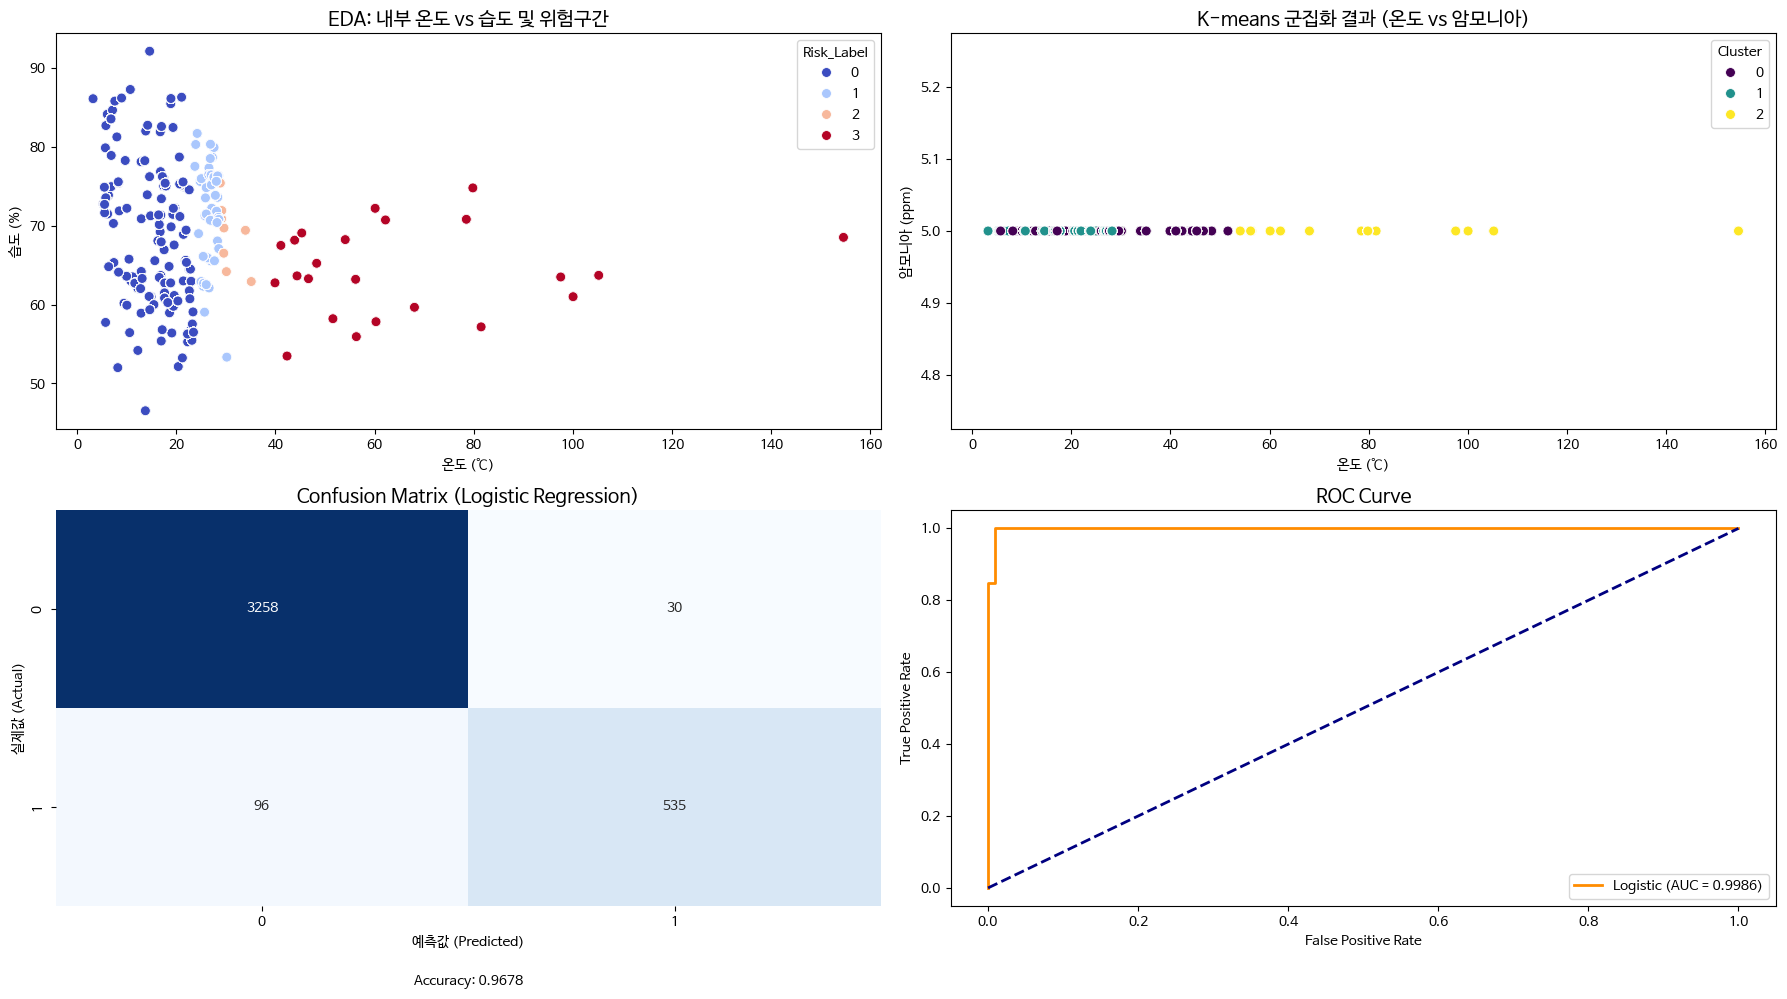


✅ 모든 분석 및 시각화가 완료되었습니다.


In [ ]:
# 1. 한글 폰트 설치 및 라이브러리 임포트
# (주의: 이 셀을 실행 후 그래프 글자가 깨지면 [런타임] -> [런타임 다시 시작] 후 다시 실행해주세요)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 로드 및 폰트 설정 완료.")

# ==========================================
# 2. 데이터 로드 및 전처리
# ==========================================

# 업로드된 파일명 (올리신 파일명과 일치해야 합니다)
FILE_ENV = '/content/ICT데이터 환경관리기(한우)_2025.11.30.xlsx'
FILE_CTRL = '/content/ICT데이터 환경제어기(한우)_2025.11.30.xlsx'
FILE_KMA = '/content/OBS_ASOS_TIM_20251130213444.csv'

try:
    print("⏳ 데이터 로드 및 병합 중...")

    # 2-1. 환경관리기 데이터 로드 (Long format -> Wide format 변환)
    # 인코딩 문제 발생 시 encoding='cp949' 또는 'euc-kr' 시도
    df_env_raw = pd.read_excel(FILE_ENV)

    # 컬럼명 매핑 (데이터 파일의 실제 컬럼명 포함 여부 확인)
    col_date = [c for c in df_env_raw.columns if '일자' in c][0]
    col_type = [c for c in df_env_raw.columns if '장비' in c][0]
    col_val = [c for c in df_env_raw.columns if '측정값' in c][0]

    # 피벗: 날짜를 기준으로 온도, 습도 등을 컬럼으로 변환
    df_env = df_env_raw.pivot_table(index=col_date, columns=col_type, values=col_val, aggfunc='mean').reset_index()
    df_env.columns.name = None

    # 영문 컬럼명으로 변경
    cols = df_env.columns
    col_map = {col_date: 'Date'}
    for c in cols:
        if '온도' in c: col_map[c] = 'Temp_In'
        if '습도' in c: col_map[c] = 'Hum_In'
        if 'NH3' in c or '암모니아' in c: col_map[c] = 'NH3'
        if 'CO2' in c: col_map[c] = 'CO2'

    df_env = df_env.rename(columns=col_map)
    df_env['Date'] = pd.to_datetime(df_env['Date'])

    # 2-2. 기상청 데이터 로드
    df_kma = pd.read_csv(FILE_KMA, encoding='cp949') # 기상청 CSV는 보통 cp949 인코딩
    df_kma['일시'] = pd.to_datetime(df_kma['일시'])
    df_kma = df_kma[['일시', '기온(°C)', '습도(%)']].rename(columns={'일시':'Date', '기온(°C)':'Temp_Out', '습도(%)':'Hum_Out'})

    # 2-3. 데이터 병합 (Merge)
    # 내부 센서 시간과 기상청 시간을 Inner Join
    df_final = pd.merge(df_env, df_kma, on='Date', how='inner')

    # 결측치 처리 (NH3, CO2가 데이터에 없는 경우 기본값 처리하여 코드 에러 방지)
    if 'NH3' not in df_final.columns: df_final['NH3'] = 5.0
    if 'CO2' not in df_final.columns: df_final['CO2'] = 600.0

    # 온습도 결측치는 삭제
    df_final = df_final.dropna(subset=['Temp_In', 'Hum_In'])

    print(f"✅ 데이터 전처리 완료: 총 {len(df_final)}건의 데이터가 준비되었습니다.")

except Exception as e:
    print(f"❌ 데이터 처리 중 오류 발생: {e}")
    print("파일명이 정확한지, 혹은 CSV 파일이 맞는지 확인해주세요.")

# ==========================================
# 3. THI 계산 및 위험 라벨링 (표준 공식)
# ==========================================

def calc_thi_standard(temp, rh):
    # 축산학 공통 표준 THI 공식
    return (1.8 * temp + 32) - (0.55 - 0.0055 * rh) * (1.8 * temp - 26)

def risk_labeling(row):
    thi = row['THI']
    nh3 = row['NH3']

    # THI 기준 위험 구간 설정 (일반적인 축산 스트레스 임계값 적용)
    # < 72: 안전 / 72~79: 주의 / 80~89: 경고 / >= 90: 위험
    label = 0 # Safe
    if thi >= 90: label = 3 # Danger
    elif thi >= 80: label = 2 # Warning
    elif thi >= 72: label = 1 # Caution

    # 가스 농도에 따른 가중치 (NH3가 높으면 최소 '경고' 이상으로 격상)
    if nh3 > 15 and label < 2:
        label = 2

    return label

# THI 및 라벨 생성
df_final['THI'] = df_final.apply(lambda x: calc_thi_standard(x['Temp_In'], x['Hum_In']), axis=1)
df_final['Risk_Label'] = df_final.apply(risk_labeling, axis=1)

# 이진 분류용 타겟 생성 (0,1:안전/주의 vs 2,3:경고/위험)
df_final['Is_Danger'] = (df_final['Risk_Label'] >= 2).astype(int)

print("✅ THI 계산 및 위험 라벨링 완료.")
print("라벨 분포:\n", df_final['Risk_Label'].value_counts().sort_index())


# ==========================================
# 4. 머신러닝 모델링
# ==========================================

# Feature & Target 설정
X = df_final[['Temp_In', 'Hum_In', 'NH3', 'CO2']]
y = df_final['Is_Danger']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링 (K-means, Logistic Regression 성능 향상)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4-1. 비지도 학습: K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['Cluster'] = kmeans.fit_predict(X_scaled)

# 4-2. 지도 학습: Naive Bayes (MLE 기반)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)

# 4-3. 지도 학습: Logistic Regression (Cross-Entropy 최소화)
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
acc_lr = accuracy_score(y_test, y_pred_lr)
ce_loss = log_loss(y_test, y_prob_lr)

print(f"\n📊 [모델 성능 요약]")
print(f" - Naive Bayes 정확도: {acc_nb:.4f}")
print(f" - Logistic Regression 정확도: {acc_lr:.4f}")
print(f" - Cross Entropy Loss: {ce_loss:.4f}")

# ==========================================
# 5. 시각화 (그래프 출력)
# ==========================================
plt.figure(figsize=(18, 10))

# 5-1. EDA: 온도 vs 습도 산점도 (위험도 등급별 색상)
plt.subplot(2, 2, 1)
sns.scatterplot(data=df_final, x='Temp_In', y='Hum_In', hue='Risk_Label', palette='coolwarm', s=50)
plt.title('EDA: 내부 온도 vs 습도 및 위험구간', fontsize=14)
plt.xlabel('온도 (℃)')
plt.ylabel('습도 (%)')

# 5-2. Clustering 결과 시각화
plt.subplot(2, 2, 2)
# X축: 온도, Y축: 암모니아 (또는 습도)
sns.scatterplot(data=df_final, x='Temp_In', y='NH3', hue='Cluster', palette='viridis', s=50)
plt.title('K-means 군집화 결과 (온도 vs 암모니아)', fontsize=14)
plt.xlabel('온도 (℃)')
plt.ylabel('암모니아 (ppm)')

# 5-3. Confusion Matrix (Logistic Regression)
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Logistic Regression)', fontsize=14)
plt.xlabel('예측값 (Predicted)')
plt.ylabel('실제값 (Actual)')
plt.text(0.5, -0.2, f'Accuracy: {acc_lr:.4f}', ha='center', transform=plt.gca().transAxes)

# 5-4. ROC Curve
plt.subplot(2, 2, 4)
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
auc_score = roc_auc_score(y_test, y_prob_lr)
plt.plot(fpr, tpr, label=f'Logistic (AUC = {auc_score:.4f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

print("\n✅ 모든 분석 및 시각화가 완료되었습니다.")